## Notebook 1: Regression and predictive modeling of Rossmann stores daily sales using machine learning and neural network models

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

In [2]:
# b) Load dataset
# Load and view each file in the dataset
raw_train = pd.read_csv('train.csv', header=0)
raw_train = raw_train.reset_index()
print(raw_train.shape)
print(raw_train.head(10))
print(raw_train.dtypes)

raw_test = pd.read_csv('test.csv', header=0)
print(raw_test.shape)
print(raw_test.head(10))
print(raw_test.dtypes)

store = pd.read_csv('store.csv', header=0)
print(store.shape)
print(store.head(10))
print(store.dtypes)

C:\Users\son.tran2\AppData\Local\Temp\ipykernel_16460\2567690122.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_train = pd.read_csv('train.csv', header=0)


(1017209, 10)
   index  Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0      0      1          5  2015-07-31   5263        555     1      1   
1      1      2          5  2015-07-31   6064        625     1      1   
2      2      3          5  2015-07-31   8314        821     1      1   
3      3      4          5  2015-07-31  13995       1498     1      1   
4      4      5          5  2015-07-31   4822        559     1      1   
5      5      6          5  2015-07-31   5651        589     1      1   
6      6      7          5  2015-07-31  15344       1414     1      1   
7      7      8          5  2015-07-31   8492        833     1      1   
8      8      9          5  2015-07-31   8565        687     1      1   
9      9     10          5  2015-07-31   7185        681     1      1   

  StateHoliday  SchoolHoliday  
0            0              1  
1            0              1  
2            0              1  
3            0              1  
4            0        

The test set doesn't have Sales and Customers features so we can't use them for validation purposes. The file Store.csv includes useful data that can aid the training process so we merge it with Train.csv data on the same column named "Store".

In [3]:
# Merge the store data to train dataset
data = raw_train.merge(store,on=["Store"], how="inner")
print(data.shape)
print(data.dtypes)

(1017209, 19)
index                          int64
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

           index      Store  DayOfWeek      Sales  Customers       Open  \
count  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06   
mean   5.086e+05  5.584e+02  3.998e+00  5.774e+03  6.331e+02  8.301e-01   
std    2.936e+05  3.219e+02  1.997e+00  3.850e+03  4.644e+02  3.755e-01   
min    0.000e+00  1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00   
25%    2.543e+05  2.800e+02  2.000e+00  3.727e+03  4.050e+02  1.000e+00   
50%    5.086e+05  5.580e+02  4.000e+00  5.744e+03  6.090e+02  1.000e+00   
75%    7.629e+05  8.380e+02  6.000e+00  7.856e+03  8.370e+02  1.000e+00   
max    1.017e+06  1.115e+03  7.000e+00  4.155e+04  7.388e+03  1.000e+00   

           Promo  SchoolHoliday  CompetitionDistance  \
count  1.017e+06      1.017e+06            1.015e+06   
mean   3.815e-01      1.786e-01            5.430e+03   
std    4.858e-01      3.831e-01            7.715e+03   
min    0.000e+00      0.000e+00            2.000e+01   
25%    0.000e+00      0.000e+00            7

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

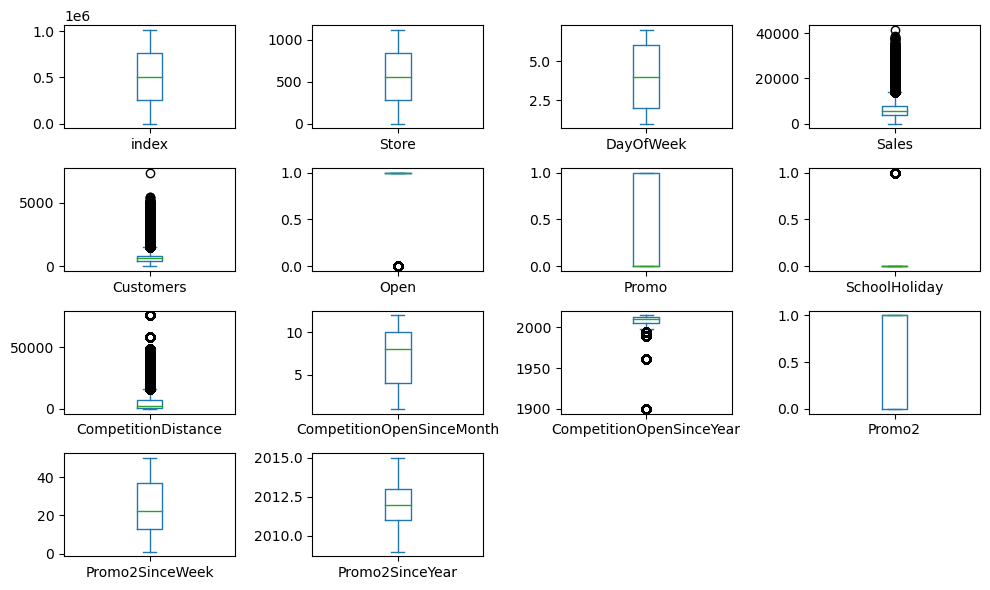

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

We can see the data skewed to the low values in Sales, Customers, and CompetitionDistance

                               index      Store  DayOfWeek  Sales  Customers  \
index                      1.000e+00  2.166e-04 -2.023e-04 -0.042     -0.013   
Store                      2.166e-04  1.000e+00 -8.484e-06  0.005      0.024   
DayOfWeek                 -2.023e-04 -8.484e-06  1.000e+00 -0.462     -0.386   
Sales                     -4.191e-02  5.126e-03 -4.621e-01  1.000      0.895   
Customers                 -1.287e-02  2.432e-02 -3.864e-01  0.895      1.000   
Open                       7.957e-05 -4.674e-05 -5.290e-01  0.678      0.617   
Promo                     -1.678e-02  5.786e-05 -3.929e-01  0.452      0.316   
SchoolHoliday             -2.068e-03  6.407e-04 -2.054e-01  0.085      0.072   
CompetitionDistance       -2.096e-03 -2.641e-02 -2.461e-05 -0.019     -0.103   
CompetitionOpenSinceMonth  3.050e-04 -5.075e-02  5.882e-06 -0.028     -0.031   
CompetitionOpenSinceYear  -2.269e-03 -4.592e-03 -2.537e-05  0.013      0.009   
Promo2                     1.465e-02  8.

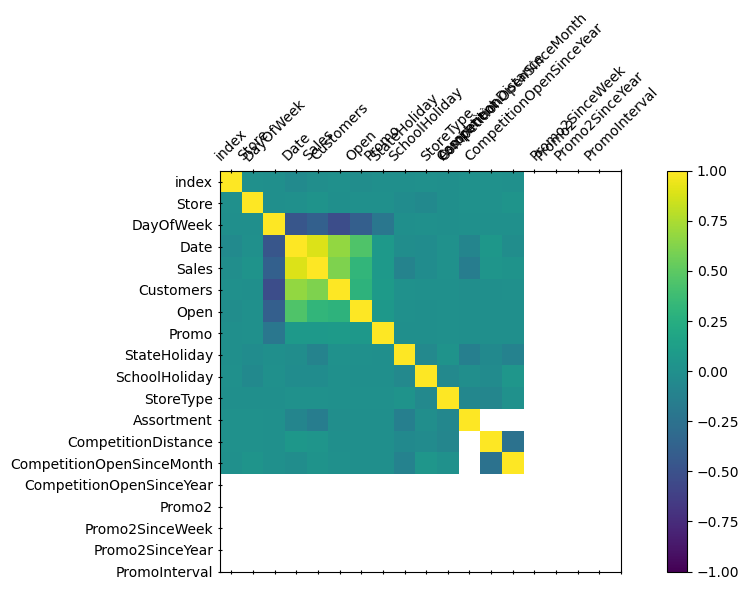

In [7]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,19))
sub_fig.set_yticks(np.arange(0,19))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates sales data is sensitive to the Date, Open and Customers features.

**3. Prepare Data**

In [8]:
# a) Data Cleaning

# Extract year, month, week, day from the Date feature

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.week
data["Day"] = data["Date"].dt.day

# Create 2 new features representing weekend and promotion
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend","Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

y_temp = data['Sales']

C:\Users\son.tran2\AppData\Local\Temp\ipykernel_16460\2610558992.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["Week"] = data["Date"].dt.week


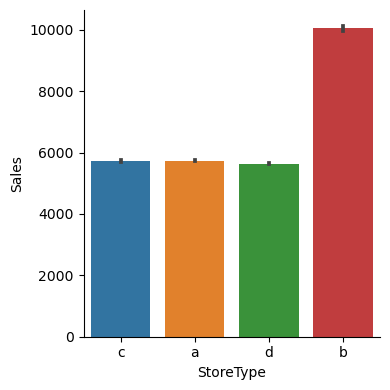

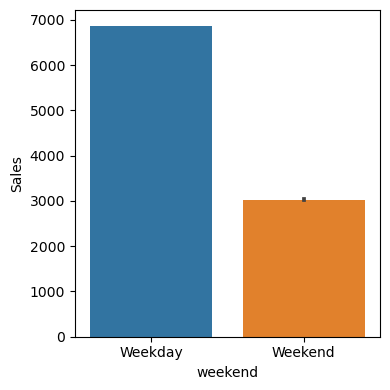

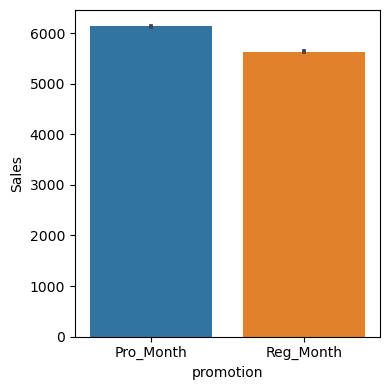

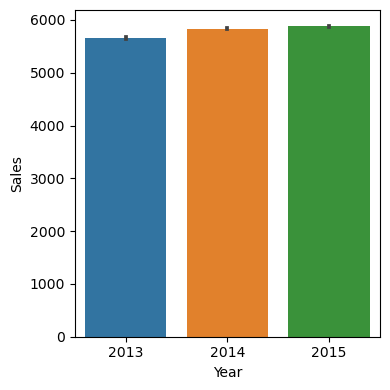

In [9]:
# Visualize Sales vs. store type 
fig1, ax1 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['StoreType'], y=y_temp, data=data, ax=ax1)

# Visualize Sales vs. weekend
fig2, ax2 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['weekend'], y=y_temp, data=data, ax=ax2)

# Visualize Sales vs. promotion months 
fig3, ax3 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['promotion'], y=y_temp, data=data, ax=ax3)

# Visualize Sales vs. year 
fig4, ax4 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['Year'], y=y_temp, data=data, ax=ax4)

sn.despine(fig1, fig2, fig3, fig4)

An interesting observation from the Sales vs Weekend chart is that sales on weekdays are generally higher than on weekends (Saturday and Sunday).

It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [10]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Sales']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [11]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

index                        996865
Store                          1094
DayOfWeek                         7
Date                            942
Sales                         21734
Customers                      4086
Open                              2
Promo                             2
StateHoliday                      5
SchoolHoliday                     2
StoreType                         4
Assortment                        3
CompetitionDistance             641
CompetitionOpenSinceMonth        12
CompetitionOpenSinceYear         20
Promo2                            2
Promo2SinceWeek                  24
Promo2SinceYear                   7
PromoInterval                     3
Year                              3
Month                            12
Week                             52
Day                              31
weekend                           2
promotion                         2
dtype: int64
index                             0
Store                             0
DayOfWeek      

In [12]:
# Impute missing values with 'mode' values in this important variable (CompetitionDistance)
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [13]:
# Convert strings into categorial classes
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
data['StoreType'] = data['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
data['Assortment'] = data['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
data['StateHoliday'] = data['StateHoliday'].replace(mapping3)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])
print(data.shape)

(1017209, 27)


In [14]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(1017209, 27)


In [15]:
# b) Split-out validation dataset and drop unimportant columns

train = data[:int(len(data) * 0.75)]
validation = data[int(len(data) * 0.75):int(len(data) * 1)]
print(train.shape, validation.shape)

X_train = train.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_val = validation.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
y_train = train['Sales']
y_val = validation['Sales']

# For XGBoost model
X_train1 = train.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
y_train1 = train['Sales']

(762906, 27) (254303, 27)


In [16]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_val = DataFrame(X_val)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(762906, 19) (254303, 19)
(762906,) (254303,)


**4. Evaluate Algorithms**

In [17]:
# a) Spot check algorithms using cross-validation technique
num_folds = 5
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor(n_estimators=10, max_features=10, random_state=seed)))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [18]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(200, input_shape = (19, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='softplus'))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_CNN = baseline_model()
models.append(('CNN', model_CNN))

In [19]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [20]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_CNN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for xgboost and CNN
    if name != ('XGB' and 'CNN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'CNN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 50})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(abs(cvs))
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, abs(cvs).mean(), abs(cvs).std())
    print(output)

LR: 1909382.475744 (14205.688536)
RF: 346659.312889 (7484.172458)
XGB: 1123925.264946 (13689.114380)


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpc25_grn_\assets


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpc25_grn_\assets


Epoch 1/50
4769/4769 [==============================] - 24s 5ms/step - loss: 28685240.0000 - mse: 28685240.0000 - val_loss: 1460509.8750 - val_mse: 1460509.8750
Epoch 2/50
4769/4769 [==============================] - 21s 4ms/step - loss: 2506635.2500 - mse: 2506635.2500 - val_loss: 8826293.0000 - val_mse: 8826293.0000
Epoch 3/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1789021.1250 - mse: 1789021.1250 - val_loss: 7946513.5000 - val_mse: 7946513.5000
Epoch 4/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1751543.7500 - mse: 1751543.7500 - val_loss: 8490801.0000 - val_mse: 8490801.0000
Epoch 5/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1723823.1250 - mse: 1723823.1250 - val_loss: 8127356.0000 - val_mse: 8127356.0000
Epoch 6/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1707598.7500 - mse: 1707598.7500 - val_loss: 8801134.0000 - val_mse: 8801134.0000
Epoch 7/50
4769/4769 [======================

INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpbig4lij2\assets


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpbig4lij2\assets


Epoch 1/50
4769/4769 [==============================] - 19s 4ms/step - loss: 28682350.0000 - mse: 28682350.0000 - val_loss: 1439138.8750 - val_mse: 1439138.8750
Epoch 2/50
4769/4769 [==============================] - 18s 4ms/step - loss: 2487125.5000 - mse: 2487125.5000 - val_loss: 8691316.0000 - val_mse: 8691316.0000
Epoch 3/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1803471.5000 - mse: 1803471.5000 - val_loss: 10047199.0000 - val_mse: 10047199.0000
Epoch 4/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1752755.1250 - mse: 1752755.1250 - val_loss: 8659849.0000 - val_mse: 8659849.0000
Epoch 5/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1724857.1250 - mse: 1724857.1250 - val_loss: 8870633.0000 - val_mse: 8870633.0000
Epoch 6/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1717368.2500 - mse: 1717368.2500 - val_loss: 9381787.0000 - val_mse: 9381787.0000
Epoch 7/50
4769/4769 [====================

INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmp0q3uyww2\assets


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmp0q3uyww2\assets


Epoch 1/50
4769/4769 [==============================] - 20s 4ms/step - loss: 28538518.0000 - mse: 28538518.0000 - val_loss: 1591014.7500 - val_mse: 1591014.7500
Epoch 2/50
4769/4769 [==============================] - 19s 4ms/step - loss: 2494211.0000 - mse: 2494211.0000 - val_loss: 7892317.0000 - val_mse: 7892317.0000
Epoch 3/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1825726.8750 - mse: 1825726.8750 - val_loss: 10175969.0000 - val_mse: 10175969.0000
Epoch 4/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1792292.0000 - mse: 1792292.0000 - val_loss: 9651582.0000 - val_mse: 9651582.0000
Epoch 5/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1776719.3750 - mse: 1776719.3750 - val_loss: 8605663.0000 - val_mse: 8605663.0000
Epoch 6/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1759042.2500 - mse: 1759042.2500 - val_loss: 9572140.0000 - val_mse: 9572140.0000
Epoch 7/50
4769/4769 [====================

INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpgqhro5ta\assets


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpgqhro5ta\assets


Epoch 1/50
4769/4769 [==============================] - 20s 4ms/step - loss: 28500974.0000 - mse: 28500974.0000 - val_loss: 1469566.1250 - val_mse: 1469566.1250
Epoch 2/50
4769/4769 [==============================] - 19s 4ms/step - loss: 2482611.5000 - mse: 2482611.5000 - val_loss: 9149166.0000 - val_mse: 9149166.0000
Epoch 3/50
4769/4769 [==============================] - 18s 4ms/step - loss: 1794741.6250 - mse: 1794741.6250 - val_loss: 9403231.0000 - val_mse: 9403231.0000
Epoch 4/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1753103.3750 - mse: 1753103.3750 - val_loss: 9435366.0000 - val_mse: 9435366.0000
Epoch 5/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1722770.6250 - mse: 1722770.6250 - val_loss: 9826167.0000 - val_mse: 9826167.0000
Epoch 6/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1702462.3750 - mse: 1702462.3750 - val_loss: 9548937.0000 - val_mse: 9548937.0000
Epoch 7/50
4769/4769 [======================

INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpob_s8igy\assets


INFO:tensorflow:Assets written to: C:\Users\son.tran2\AppData\Local\Temp\tmpob_s8igy\assets


Epoch 1/50
4769/4769 [==============================] - 20s 4ms/step - loss: 28753886.0000 - mse: 28753886.0000 - val_loss: 1463963.2500 - val_mse: 1463963.2500
Epoch 2/50
4769/4769 [==============================] - 19s 4ms/step - loss: 2482076.2500 - mse: 2482076.2500 - val_loss: 9374229.0000 - val_mse: 9374229.0000
Epoch 3/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1784042.5000 - mse: 1784042.5000 - val_loss: 9137916.0000 - val_mse: 9137916.0000
Epoch 4/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1747610.7500 - mse: 1747610.7500 - val_loss: 9489504.0000 - val_mse: 9489504.0000
Epoch 5/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1726127.1250 - mse: 1726127.1250 - val_loss: 9425771.0000 - val_mse: 9425771.0000
Epoch 6/50
4769/4769 [==============================] - 19s 4ms/step - loss: 1704978.6250 - mse: 1704978.6250 - val_loss: 9134426.0000 - val_mse: 9134426.0000
Epoch 7/50
4769/4769 [======================

Of the three algorithms, the ensemble models outperformed Linear Regression. Interestingly, Random Forest outperforms XGBoost, which is considered to be one of the strongest tree-based regression algorithms, and even the CNN model.

Epoch 1/50
5961/5961 [==============================] - 24s 4ms/step - loss: 23779834.0000 - mse: 23779834.0000 - val_loss: 4127658.7500 - val_mse: 4127658.7500
Epoch 2/50
5961/5961 [==============================] - 22s 4ms/step - loss: 1833223.5000 - mse: 1833223.5000 - val_loss: 9663794.0000 - val_mse: 9663794.0000
Epoch 3/50
5961/5961 [==============================] - 22s 4ms/step - loss: 1719660.6250 - mse: 1719660.6250 - val_loss: 7873510.5000 - val_mse: 7873510.5000
Epoch 4/50
5961/5961 [==============================] - 22s 4ms/step - loss: 1679298.6250 - mse: 1679298.6250 - val_loss: 9448214.0000 - val_mse: 9448214.0000
Epoch 5/50
5961/5961 [==============================] - 23s 4ms/step - loss: 1655667.7500 - mse: 1655667.7500 - val_loss: 9119738.0000 - val_mse: 9119738.0000
Epoch 6/50
5961/5961 [==============================] - 23s 4ms/step - loss: 1653816.5000 - mse: 1653816.5000 - val_loss: 8667424.0000 - val_mse: 8667424.0000
Epoch 7/50
5961/5961 [======================

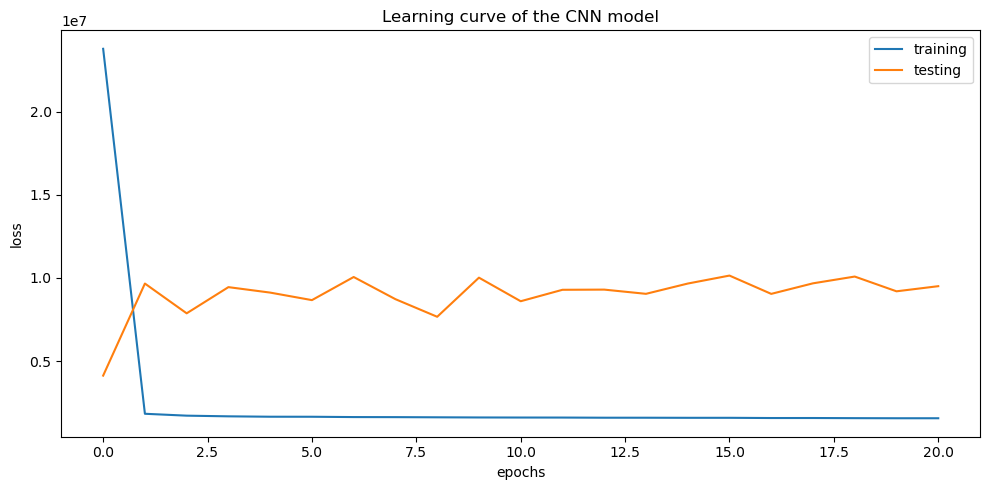

In [21]:
# Plot learning curve of CNN model
history = model_CNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the CNN model')
plt.legend()

The learning curve suggests CNN model experienced some extent of overfitting even though BatchNormalization and Dropout were implemented in the model setup.

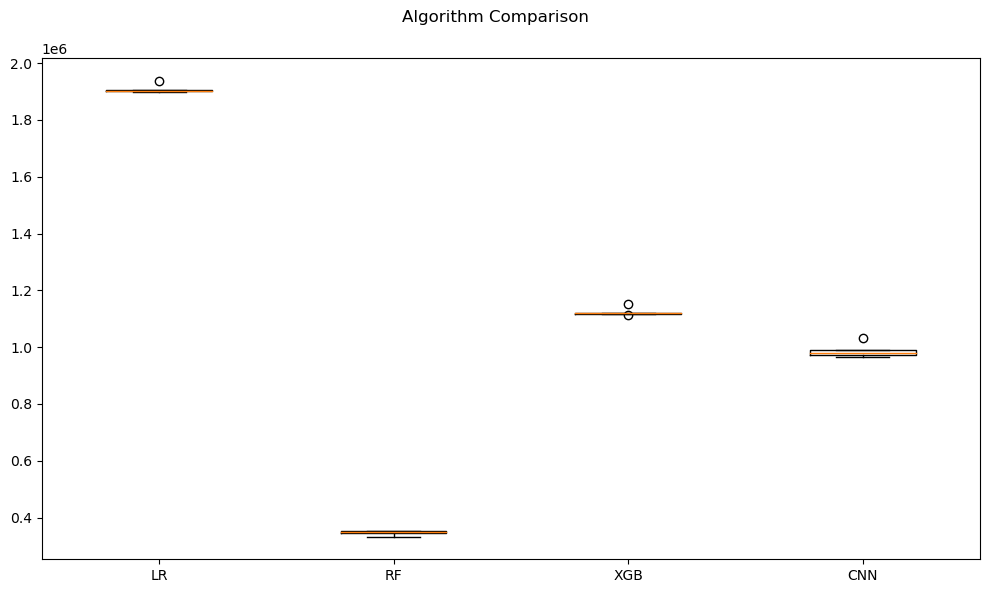

In [22]:
# Distribution of accuracy values calculated across 5 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.show()

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data.

In [23]:
# Define baseline mean_absolute_error of y_test in the data set
y_mean = np.mean(y_temp)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  2798.9021336173982


In [24]:
# Calculate mean_absolute_error of the prediction
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_val, y_val)
y_pred_RF = model_RF.predict(X_val)

mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  117.96169431740874


Of the three ML algorithms and the neural network model, Random Forest demonstrated superior performance in terms of MSE (from cross-validation) and MAE values and was chosen as the optimal model.

**5. Finalize Model**

In [25]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


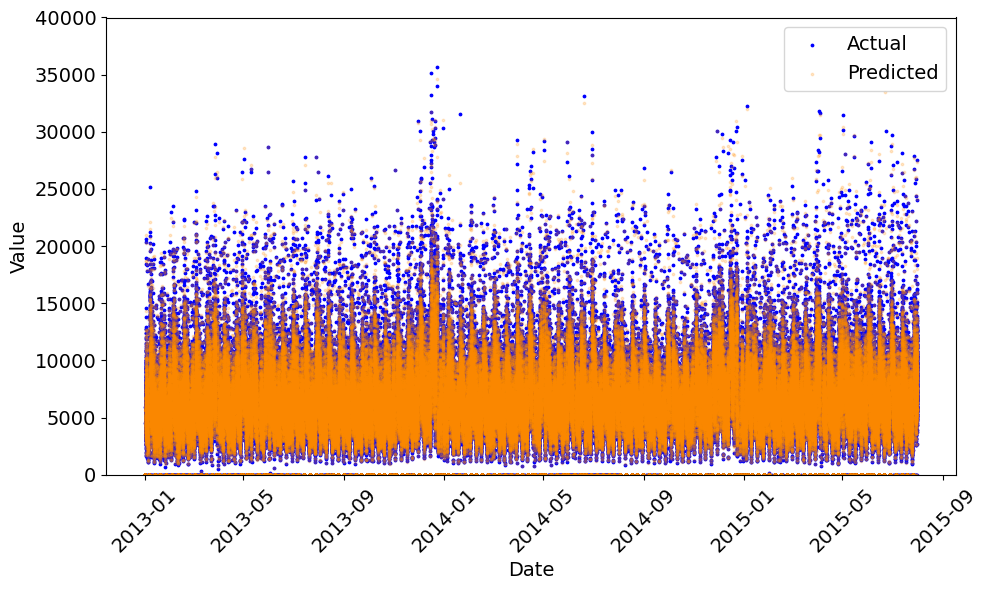

In [26]:
# Create a scatter plot of predicted and actual sales data
# remove the first 7 days of validation['Date'] to match the shape of y_pred_trans and y_val
dates = validation['Date']

# set the width of the scatter points
scatter_size = 3

# create a figure and axis object
fig, ax = plt.subplots()
ax.set_ylim(top=40000)

# plot the actual data as blue scatter points
ax.scatter(dates, y_val, s=scatter_size, label='Actual', color='blue')

# plot the predicted data as dark orange scatter points with lower opacity
ax.scatter(dates, y_pred_RF, s=scatter_size, label='Predicted', color='darkorange', alpha=0.2)

# add labels and legend
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)

# set tick font size for both axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# rotate the x-axis labels by 45 degrees for better visibility
plt.xticks(rotation=45)

# show the plot
plt.show()

In [27]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.

- Random Forest achieved the lowest Mean Squared Error value out of the three machine learning algorithms (Random Forest, XGBoost, and Linear Regression) and the convolutional neural network model.

- The Keras Sequential neural network model with 3 layers, dropout regularization, and BatchNormalization performed comparably to the XGBoost model. However, further hyperparameter tuning may improve the prediction score.